In [1]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import itertools
import matplotlib.pyplot as plt
import math

# Utils

In [2]:
"""
imgs:  tensor, b, c, h, w
show nrow*nrow images at most
"""
def imshow(imgs, nrow=2):
    # tile first nrow*nrow imgs
    im = torchvision.utils.make_grid(imgs[0:nrow*nrow, :, :, :], nrow=nrow, 
                                     padding=2, pad_value=1.0)  # input: B,C,H,W  output: C=3, H1, W1
    npimg = im.numpy() if not im.requires_grad else im.detach().numpy()  
    plt.figure()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # chw -> hwc
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Define AutoEncoder

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()  # i.e., super(xxx, self).__init__()
        
        self.codes = None
        
        self.encoder = nn.Sequential(
            # in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True
            nn.Conv2d(1, 1, 3, stride=2, padding=1, bias=True), 
            nn.Conv2d(1, 1, 3, stride=2, padding=1, bias=True), 
        )
        
        self.decoder = nn.Sequential(
            # k' = k
            # s'= 1, d' = s （i.e., s' = 1/s）, 
            # p’ = k - p - 1
            # a' is out_padding
            # !!! Here, in ConvTranspose2d, stride, padding, dilation use the params from Conv2d !!!
            nn.ConvTranspose2d(1, 1, 3, stride=2, padding=1, output_padding=1, bias=True),
            nn.ConvTranspose2d(1, 1, 3, stride=2, padding=1, output_padding=1, bias=True),
        )
        
        # init parameters
        for m in itertools.chain(self.encoder.modules(), self.decoder.modules()):
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.xavier_uniform_(m.weight)   # limit = 1/sqrt(fan_in)
                #nn.init.constant_(m.weight, 1./ (m.kernel_size[0] * m.kernel_size[1]) )
            
                
    def forward(self, x):
        self.codes = self.encoder(x)
        return self.decoder(self.codes)

# Input Data

torch.Size([4, 1, 28, 28])


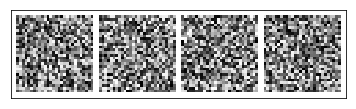

In [4]:
batch = 4
channel = 1
dim_in = 28
inputs = torch.rand(batch, channel, dim_in, dim_in)  # b, c, h, w
print(inputs.size())
imshow(inputs, nrow=4)

# Training

In [5]:
lr = 1e-3
ae = AutoEncoder()
solver = torch.optim.Adam(ae.parameters(), lr=lr)

## pre-checking

In [6]:
outs = ae(inputs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 1, 7, 7])


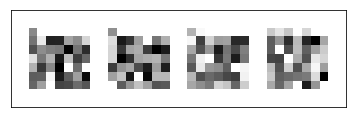

In [7]:
print(ae.codes.size())
imshow(ae.codes, nrow=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 1, 28, 28])


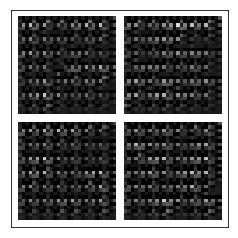

In [8]:
print(outs.size())
imshow(outs)

In [9]:
loss = torch.functional.F.mse_loss(inputs, outs, reduction='mean')
print(loss)

tensor(0.2788, grad_fn=<MeanBackward0>)


## Training starts

In [10]:
for epoch in range(3000):
    outs = ae(inputs)
    loss = torch.functional.F.mse_loss(inputs, outs, reduction='mean')

    solver.zero_grad()
    loss.backward()
    solver.step()
    if epoch % 100 == 0:
        print("epoch {}:  loss = {}".format(epoch, loss.item()))

epoch 0:  loss = 0.27875399589538574
epoch 100:  loss = 0.16928556561470032
epoch 200:  loss = 0.11804339289665222
epoch 300:  loss = 0.09751390665769577
epoch 400:  loss = 0.08946049958467484
epoch 500:  loss = 0.08573973923921585
epoch 600:  loss = 0.08389348536729813
epoch 700:  loss = 0.08289645612239838
epoch 800:  loss = 0.0822652280330658
epoch 900:  loss = 0.08177146315574646
epoch 1000:  loss = 0.08133890479803085
epoch 1100:  loss = 0.0809718668460846
epoch 1200:  loss = 0.08068478107452393
epoch 1300:  loss = 0.08046489208936691
epoch 1400:  loss = 0.08028436452150345
epoch 1500:  loss = 0.08011975884437561
epoch 1600:  loss = 0.07995450496673584
epoch 1700:  loss = 0.07977549731731415
epoch 1800:  loss = 0.07957106083631516
epoch 1900:  loss = 0.07933136075735092
epoch 2000:  loss = 0.07905234396457672
epoch 2100:  loss = 0.07874348759651184
epoch 2200:  loss = 0.07843346148729324
epoch 2300:  loss = 0.07815975695848465
epoch 2400:  loss = 0.07794363796710968
epoch 2500:  l

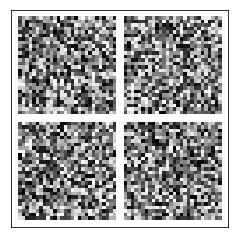

In [11]:
imshow(inputs)

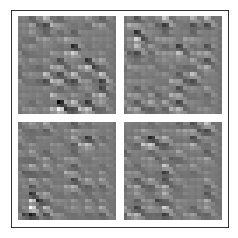

In [12]:
imshow(outs)

In [13]:
for p in ae.named_parameters():
    print(p)

('encoder.0.weight', Parameter containing:
tensor([[[[ 0.0866,  0.1120,  0.1031],
          [-0.7567, -0.5469, -0.0272],
          [-0.1911, -0.3273, -0.2673]]]], requires_grad=True))
('encoder.0.bias', Parameter containing:
tensor([-0.0856], requires_grad=True))
('encoder.1.weight', Parameter containing:
tensor([[[[ 0.0920, -0.2112,  0.0625],
          [-0.1550, -0.6208,  0.1231],
          [ 0.2572,  0.5251, -0.2050]]]], requires_grad=True))
('encoder.1.bias', Parameter containing:
tensor([-0.1424], requires_grad=True))
('decoder.0.weight', Parameter containing:
tensor([[[[-0.2732,  0.1052, -0.1390],
          [ 0.0744,  0.8305, -0.1481],
          [-0.4202, -0.7623,  0.2439]]]], requires_grad=True))
('decoder.0.bias', Parameter containing:
tensor([0.1063], requires_grad=True))
('decoder.1.weight', Parameter containing:
tensor([[[[ 0.0072, -0.0612, -0.0408],
          [ 0.5898,  0.3970, -0.0460],
          [ 0.1647,  0.2189,  0.1923]]]], requires_grad=True))
('decoder.1.bias', Parame